# Spectral Analysis of Kernels

**Goal.** Compare several feature maps (Amplitude, Angle, ZZ) via kernel spectra and label-structure diagnostics.

**Dataset.** Exactly the first 59 samples of class 0 and the next 71 samples of class 1 (total 130 points).  
We will:
1. Build the Gram matrix $K$ for each feature map.
2. Symmetrize $K \leftarrow \frac12(K+K^\top)$.
3. Center the kernel for diagnostics: $K_c = H K H$, with $H = I - \frac{1}{n}\mathbf{1}\mathbf{1}^\top$.
4. Spectrum: eigenvalues of $K_c$; Scree plot; effective rank $r_\text{eff} = \sum_i \lambda_i^2 / \sum_i \lambda_i^2$.
5. Label structure: distributions of within-class vs between-class similarities from $K$.

**Interpretation**:
- Good spread: several sizable eigenvalues → multiple informative directions.
- Identity-like: many similar eigenvalues → weak structure; hard separation.
- Near rank-1: one dominant eigenvalue → samples look nearly identical; also hard.


In [ ]:
pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 46.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA

import pennylane as qml
from itertools import combinations

# Plot defaults
plt.rcParams["figure.figsize"] = (6,4)
np.set_printoptions(precision=4, suppress=True)

# Reproducibility
seed = 1234
rng = np.random.default_rng(seed)
np.random.seed(seed)


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


## Data: Binary Wine

- Keep 59 samples of class 0 and 71 of class 1: `x = x[:59+71]`, `y = y[:59+71]`.
- Scale with MaxAbsScaler on train-like split (here we treat the whole 130 points as one set for pure kernel analysis).
- Clip to $[0,1]$ for amplitude/angle embeddings.


In [ ]:
# Load Wine
X_all, y_all = load_wine(return_X_y=True)

# Exact binary slice: first 59 -> class 0, next 71 -> class 1
X = X_all[:59+71]
y = y_all[:59+71]
print("Data shape:", X.shape, "| labels:", np.unique(y, return_counts=True))

# Scale (MaxAbs) and clip to [0,1]
scaler = MaxAbsScaler()
X = scaler.fit_transform(X)
X = np.clip(X, 0.0, 1.0)


Data shape: (130, 13) | labels: (array([0, 1]), array([59, 71]))


## Utilities: Gram building, symmetrization, centering, spectrum & plots

- Centering: $K_c = HKH$ with $H = I - \frac{1}{n}\mathbf{1}\mathbf{1}^\top$.
- Scree: eigenvalues $\lambda_i$ of $K_c$ in descending order.
- Effective rank: $r_\text{eff} = (\sum \lambda_i)^2 / \sum \lambda_i^2$ (clip tiny negatives to 0 for stability).
- Same vs different class similarities: histograms from symmetrized $K$.


In [ ]:
def symmetrize(K):
    return 0.5 * (K + K.T)

def center_kernel(K):
    n = K.shape[0]
    H = np.eye(n) - np.ones((n,n))/n
    return H @ K @ H

def spectrum(Kc):
    # Kc should be symmetric; eigh returns sorted ascending → flip
    # Note that we symmetrize again for precaution (rounding error might introduce asymm.)
    w, _ = np.linalg.eigh((Kc + Kc.T) * 0.5)
    w = w[::-1]
    return w

def effective_rank(eigs, clip_at=0.0):
    # Clip tiny negatives from numerical issues before r_eff
    lam = np.copy(eigs)
    lam[lam < clip_at] = 0.0
    s1 = lam.sum()
    s2 = (lam**2).sum()
    return (s1**2 / s2) if s2 > 0 else 0.0

def scree_plot(eigs, title="Scree plot"):
    x = np.arange(1, len(eigs)+1)
    plt.figure()
    plt.plot(x, eigs, marker='o')
    plt.xlabel("Component index (desc)")
    plt.ylabel("Eigenvalue of $K_c$")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def similarity_distributions(K, y, title="Within vs Between similarities"):
    # Use upper triangle i<j to avoid duplicates/self
    n = K.shape[0]
    within, between = [], []
    for i in range(n):
        for j in range(i+1, n):
            if y[i] == y[j]:
                within.append(K[i,j])
            else:
                between.append(K[i,j])

    plt.figure()
    bins = 20
    plt.hist(within, bins=bins, alpha=0.7, label="Within-class")
    plt.hist(between, bins=bins, alpha=0.7, label="Between-class")
    plt.xlabel("Similarity K[i,j]")
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def diagnostic_report(K, y, label):
    # 1) Symmetrize
    K_sym = symmetrize(K)
    # 2) Center
    Kc = center_kernel(K_sym)
    # 3) Spectrum
    eigs = spectrum(Kc)
    r_eff = effective_rank(eigs, clip_at=0.0)

    print(f"[{label}]  n={K.shape[0]}")
    print(f"  Sum eigs: {eigs.sum():.4f}  |  r_eff: {r_eff:.2f}")
    print(f"  Top-5 eigs: {np.round(eigs[:5], 6)}")

    # 4) Plots
    scree_plot(eigs, title=f"Scree — {label}")
    similarity_distributions(K_sym, y, title=f"Similarities — {label}")

    return {"label": label, "eigs": eigs, "r_eff": r_eff, "K_sym": K_sym, "Kc": Kc}


## Feature map A - Amplitude-encoding

- Use 4 qubits since $2^4=16 \ge 13$ features (we already clipped to $[0,1]$).
- Overlap via inverse-circuit: embed $x$, then adjoint embedding of $z$.
- Kernel entry is the probability of $|0\ldots 0\rangle$.


[Amplitude]  n=130
  Sum eigs: 10.6672  |  r_eff: 4.99
  Top-5 eigs: [4.0654 1.746  1.1836 0.7815 0.7272]


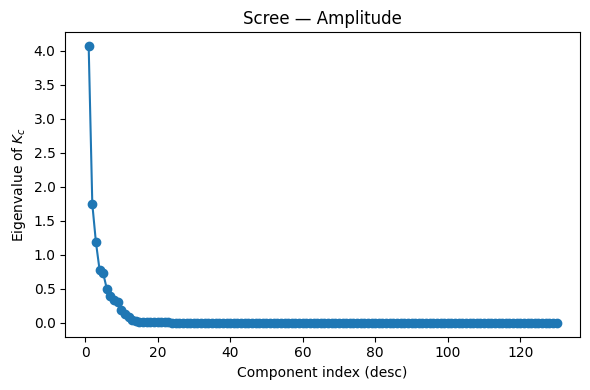

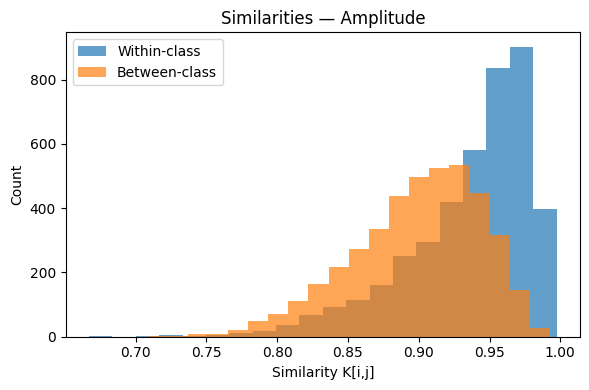

In [ ]:
nqubits_amp = 4
dev_amp = qml.device("lightning.qubit", wires=nqubits_amp)

@qml.qnode(dev_amp)
def overlap_amp(a, b):
    qml.AmplitudeEmbedding(a, wires=range(nqubits_amp), pad_with=0.0, normalize=True)
    qml.adjoint(qml.AmplitudeEmbedding)(b, wires=range(nqubits_amp), pad_with=0.0, normalize=True)
    return qml.probs(wires=range(nqubits_amp))  # index 0

def gram_from_pairs(X, pair_kernel):
    n = X.shape[0]
    K = np.empty((n,n), dtype=float)
    for i in range(n):
        for j in range(n):
            K[i,j] = pair_kernel(X[i], X[j])[0]  # take prob of |0..0>
    return K

K_amp = gram_from_pairs(X, overlap_amp)
_ = diagnostic_report(K_amp, y, label="Amplitude")



##  PCA for Angle/ZZ maps

Angle/ZZ maps typically use one qubit per component. To compare fairly and keep circuits shallow, reduce to `n_components` principal components (fit on the same set for analysis purposes).


In [ ]:
n_components = 8  # adjust if you want fewer/more qubits for angle/zz
pca = PCA(n_components=n_components, random_state=seed)
X_pca = pca.fit_transform(X)
print("PCA shape:", X_pca.shape)


PCA shape: (130, 8)


## Feature map B - Angle-encoding

- Map each PCA component to a rotation on a distinct qubit.
- Overlap via adjoint AngleEmbedding.


[Angle (PCA)]  n=130
  Sum eigs: 13.9719  |  r_eff: 4.02
  Top-5 eigs: [6.2808 1.9811 1.5234 1.0854 0.8382]


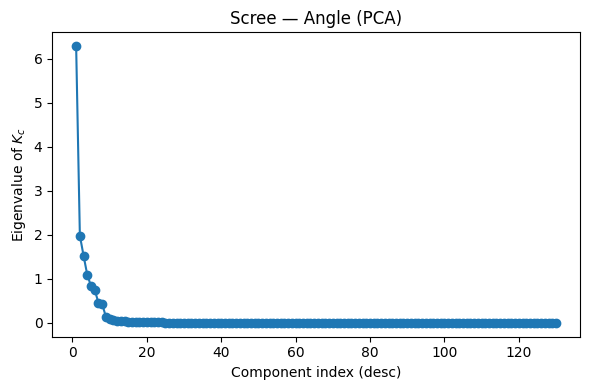

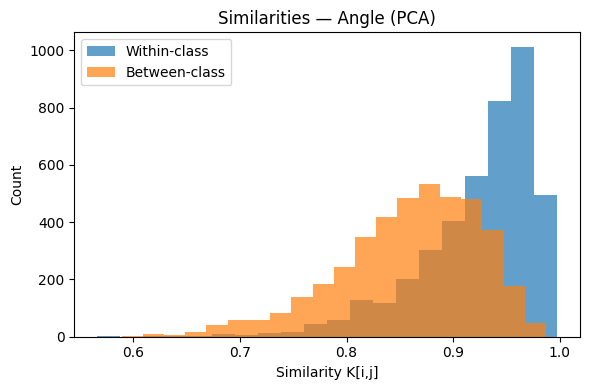

In [ ]:
nqubits_ang = X_pca.shape[1]
dev_ang = qml.device("lightning.qubit", wires=nqubits_ang)

@qml.qnode(dev_ang)
def overlap_ang(a, b):
    qml.AngleEmbedding(a, wires=range(nqubits_ang))
    qml.adjoint(qml.AngleEmbedding)(b, wires=range(nqubits_ang))
    return qml.probs(wires=range(nqubits_ang))

def gram_from_pairs_pca(Xp, pair_kernel):
    n = Xp.shape[0]
    K = np.empty((n,n), dtype=float)
    for i in range(n):
        for j in range(n):
            K[i,j] = pair_kernel(Xp[i], Xp[j])[0]
    return K

K_ang = gram_from_pairs_pca(X_pca, overlap_ang)
_ = diagnostic_report(K_ang, y, label="Angle (PCA)")


## Feature map C - ZZ feature map

- Small entangling map: Hadamards + RZ(data) + pairwise CZ.
- Use a few qubits (e.g., 4). Use the first `nqubits_zz` PCA components.


[ZZ (PCA first 4)]  n=130
  Sum eigs: 113.6719  |  r_eff: 19.98
  Top-5 eigs: [12.0792 10.4716  8.3672  7.4727  6.2861]


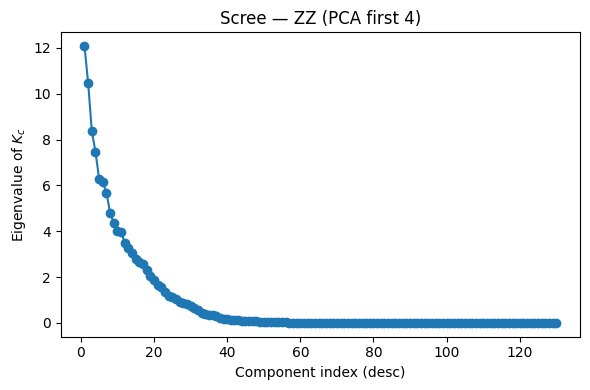

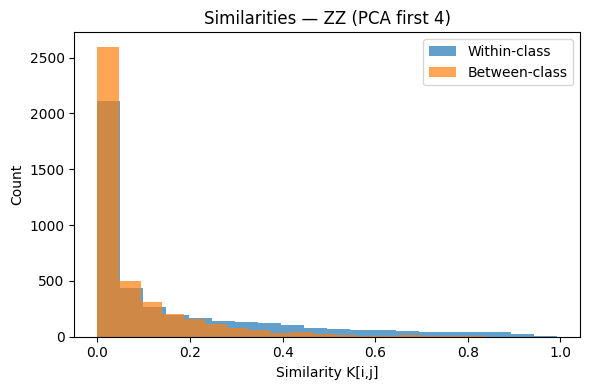

In [ ]:
def ZZFeatureMap(nqubits, data):
    nload = min(len(data), nqubits)
    for i in range(nload):
        qml.Hadamard(i)
        qml.RZ(2.0 * data[i], wires=i)
    for (q0, q1) in combinations(range(nload), 2):
        qml.CZ(wires=[q0, q1])
        qml.RZ(2.0 * (np.pi - data[q0]) * (np.pi - data[q1]), wires=q1)
        qml.CZ(wires=[q0, q1])

nqubits_zz = 4
dev_zz = qml.device("lightning.qubit", wires=nqubits_zz)

@qml.qnode(dev_zz)
def overlap_zz(a, b):
    ZZFeatureMap(nqubits_zz, a)
    qml.adjoint(ZZFeatureMap)(nqubits_zz, b)
    return qml.probs(wires=range(nqubits_zz))

Xp_zz = X_pca[:, :nqubits_zz]  # take first components for this map
def gram_from_pairs_zz(Xz, pair_kernel):
    n = Xz.shape[0]
    K = np.empty((n,n), dtype=float)
    for i in range(n):
        for j in range(n):
            K[i,j] = pair_kernel(Xz[i], Xz[j])[0]
    return K

K_zz = gram_from_pairs_zz(Xp_zz, overlap_zz)
_ = diagnostic_report(K_zz, y, label="ZZ (PCA first 4)")


## Comparison: Effective rank & overlayed scree

Compare the effective rank and scree curves across feature maps.


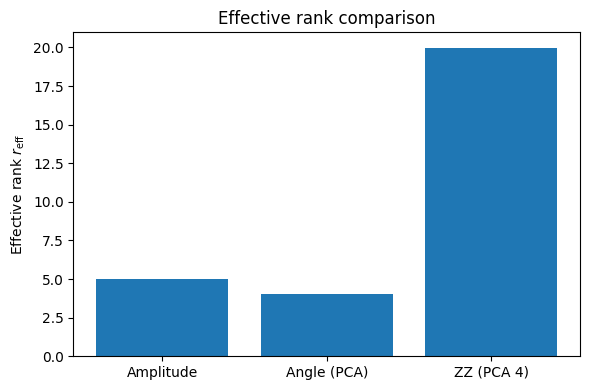

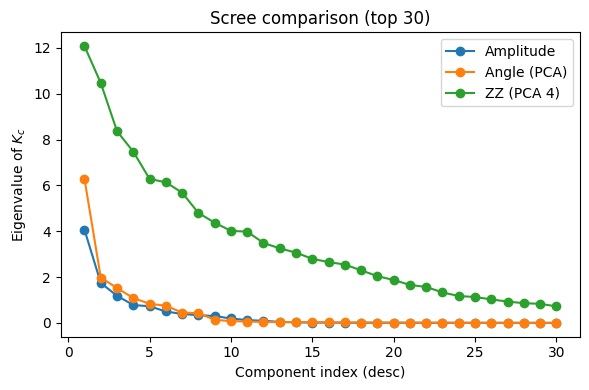

In [ ]:
# Collect reports (recompute r_eff/spectra to be sure everything available)
def summarize(K, label):
    K_sym = symmetrize(K)
    Kc = center_kernel(K_sym)
    eigs = spectrum(Kc)
    return label, eigs, effective_rank(eigs, clip_at=0.0)

summaries = [
    summarize(K_amp, "Amplitude"),
    summarize(K_ang, "Angle (PCA)"),
    summarize(K_zz,  "ZZ (PCA 4)"),
]

# Bar chart of effective ranks
labels = [s[0] for s in summaries]
ranks  = [s[2] for s in summaries]

plt.figure()
plt.bar(labels, ranks)
plt.ylabel("Effective rank $r_\\mathrm{eff}$")
plt.title("Effective rank comparison")
plt.tight_layout()
plt.show()

# Overlay scree (top N for readability)
topN = 30
plt.figure()
for name, eigs, _ in summaries:
    plt.plot(np.arange(1, min(topN, len(eigs))+1), eigs[:topN], marker='o', label=name)
plt.xlabel("Component index (desc)")
plt.ylabel("Eigenvalue of $K_c$")
plt.title(f"Scree comparison (top {topN})")
plt.legend()
plt.tight_layout()
plt.show()


## Notes & options

- **Runtime:** Each Gram matrix is $O(n^2)$ overlaps. For $n=130$, that's 16,900 circuit evaluations per map; consider reducing `n_components` or sub-sampling points for faster runs.
- **Centering:** Always use centered $K_c$ for spectral diagnostics, un-centered $K$ for within/between similarity distributions.
- **Stability:** If you estimate kernels with finite shots/noise, small PSD violations may appear. Then: symmetrize $K$, optionally add tiny diagonal jitter $\varepsilon I$, and clip tiny negative eigenvalues when computing $r_\mathrm{eff}$.


In [ ]:
# 1) What fraction of off-diagonals are (near-)zero?
import numpy as np

def offdiag_values(K):
    n = K.shape[0]
    idx = np.triu_indices(n, k=1)
    return K[idx]

vals = offdiag_values(K_zz)  # use your ZZ Gram matrix
thr = 1e-10
print("Off-diagonal mean:", vals.mean())
print("Off-diagonal median:", np.median(vals))
print("Fraction |K_ij|<1e-10:", np.mean(np.abs(vals) < thr))

Off-diagonal mean: 0.1188221083194973
Off-diagonal median: 0.031213601028481225
Fraction |K_ij|<1e-10: 0.0007155635062611807


In [ ]:
# 2) Compare within vs between summary stats
def within_between_stats(K, y):
    n = K.shape[0]
    win, bet = [], []
    for i in range(n):
        for j in range(i+1, n):
            (win if y[i]==y[j] else bet).append(K[i,j])
    win, bet = np.array(win), np.array(bet)
    print("Within  mean/median:", win.mean(), np.median(win))
    print("Between mean/median:", bet.mean(), np.median(bet))
    return win, bet

_ = within_between_stats(K_zz, y)


Within  mean/median: 0.16027912130647962 0.04851928271552469
Between mean/median: 0.07729581887252245 0.020835422314371712


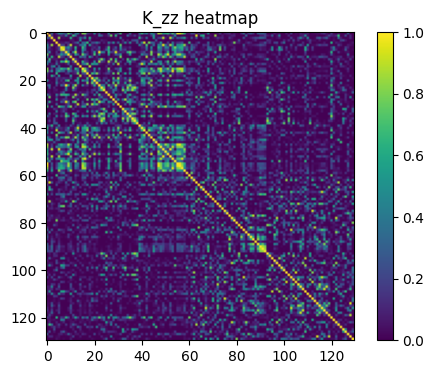

In [ ]:
# 3) Visual sanity: heatmap (expect bright diagonal, dark elsewhere if identity-like)
import matplotlib.pyplot as plt
plt.imshow(K_zz, cmap="viridis")
plt.colorbar(); plt.title("K_zz heatmap"); plt.show()



In [ ]:
import numpy as np

def centered_alignment(K, y):
    # y ∈ {0,1} → {-1,+1}
    y_pm = 2*y.astype(int) - 1
    Y = np.outer(y_pm, y_pm)
    n = len(y)
    H = np.eye(n) - np.ones((n,n))/n
    Kc = H @ ((K + K.T)/2) @ H
    Yc = H @ Y @ H
    num = np.sum(Kc * Yc)
    den = np.linalg.norm(Kc, 'fro') * np.linalg.norm(Yc, 'fro')
    return num/den if den > 0 else 0.0

print("Align(ZZ) :", centered_alignment(K_zz,  y))
print("Align(Ang):", centered_alignment(K_ang, y))
print("Align(Amp):", centered_alignment(K_amp, y))


Align(ZZ) : 0.2609333747846596
Align(Ang): 0.6526413354210999
Align(Amp): 0.5774187060044907


In [ ]:
def spec_summaries(K):
    # center & eigens
    n = K.shape[0]
    H = np.eye(n) - np.ones((n,n))/n
    Kc = H @ ((K + K.T)/2) @ H
    w, _ = np.linalg.eigh(Kc)
    w = w[::-1]
    w[w < 0] = 0.0
    s = w.sum()
    reff = (s**2)/np.sum(w**2) if np.sum(w**2) > 0 else 0.0
    reff_norm = reff / max(1, n-1)
    p = w/s if s > 0 else w
    # spectral entropy in [0,1]
    eps = 1e-12
    Hs = -np.sum(p*(np.log(p+eps))) / np.log(max(2, len(w)))
    return dict(reff=reff, reff_norm=reff_norm, spec_entropy=Hs, eigs=w)

for name, K in [("ZZ", K_zz), ("Angle", K_ang), ("Amplitude", K_amp)]:
    s = spec_summaries(K)
    print(f"{name:9s}  r_eff={s['reff']:.2f}  r_eff_norm={s['reff_norm']:.3f}  spec_entropy={s['spec_entropy']:.3f}")


ZZ         r_eff=19.98  r_eff_norm=0.155  spec_entropy=0.675
Angle      r_eff=4.02  r_eff_norm=0.031  spec_entropy=0.388
Amplitude  r_eff=4.99  r_eff_norm=0.039  spec_entropy=0.424


## Pairwise AUC from kernel similarities

We have a binary dataset $\{(x_i,y_i)\}_{i=1}^n$ with $y_i\in\{0,1\}$ and a (symmetrized) kernel matrix $K\in\mathbb{R}^{n\times n}$. Each off-diagonal entry $K_{ij}$ ($i\neq j$) is a similarity score between $x_i$ and $x_j$.

We turn pairwise similarities into a binary ranking problem:

- Positive (same-class) pairs: $y_i=y_j$.
- Negative (different-class) pairs: $y_i\neq y_j$.
- Scores: $s_{ij}=K_{ij}$, collected for $i<j$ (use only the upper triangle and skip the diagonal).

Let $S^+=\{s_{ij}:y_i=y_j,\,i<j\}$ and $S^-=\{s_{ij}:y_i\neq y_j,\,i<j\}$.

The ROC curve is traced by thresholding the score $t$ and plotting the true-positive rate (TPR) against the false-positive rate (FPR):
\begin{equation}
\mathrm{TPR}(t)=\Pr(s^+\ge t), \qquad \mathrm{FPR}(t)=\Pr(s^-\ge t).
\end{equation}

The Area Under the ROC Curve (AUC) is
\begin{equation}
\mathrm{AUC}=\int_0^1 \mathrm{TPR}(u)\,d(\mathrm{FPR}(u)).
\end{equation}
Equivalently, AUC is the probability that a random same-class pair receives a higher similarity than a random different-class pair (with ties half-credited):
\begin{equation}
\mathrm{AUC}=\Pr(s^+>s^-)+\tfrac{1}{2}\Pr(s^+=s^-).
\end{equation}

**Interpretation.**
- $\mathrm{AUC}=0.5$: random ranking (no class signal).
- $\mathrm{AUC}\to 1$: same-class pairs are consistently more similar than different-class pairs (strong label alignment).

**Notes.**
- Use the raw/symmetrized kernel $K$ (not the centered $K_c$) for pairwise AUC and within/between histograms.
- Exclude self-pairs $K_{ii}$ and use $i<j$ to avoid duplicates.
- In code, build vectors of labels $\ell_{ij}\in\{0,1\}$ (1 for same class) and scores $s_{ij}=K_{ij}$ for $i<j$, then pass them to a standard AUC routine (e.g., `roc_auc_score`).


In [ ]:
from sklearn.metrics import roc_auc_score

def pair_auc(K, y):
    n = len(y)
    L, S = [], []
    for i in range(n):
        for j in range(i+1, n):
            L.append(1 if y[i]==y[j] else 0)
            S.append(K[i,j])
    return roc_auc_score(L, S)

print("Pairwise AUC — ZZ     :", pair_auc(K_zz,  y))
print("Pairwise AUC — Angle  :", pair_auc(K_ang, y))
print("Pairwise AUC — Amp    :", pair_auc(K_amp, y))


Pairwise AUC — ZZ     : 0.5966436677293406
Pairwise AUC — Angle  : 0.7998730617048009
Pairwise AUC — Amp    : 0.7484365971889244
